# **Chapter Five: Supervised Learning**

There are two different types of classification approaches, known as either *supervised* or *unsupervised* learning. In both instances, the end goal is to be able to make assumptions about new data based on sampled values. In supervised learning, the grouping or categorization of our data is known and parameters are fit to maximize the correct labeling of known data. In unsupervised learning the aim is to find connections in unlabeled data. The goal of this chapter is to cover the mathematics behind approaches known as *supervised learning*. This first notebook in this series tackles *linear regression.*

## **5.1 Linear Regression**

One of the most often employed algorithms used in classification, and an algorithm that will serve you well in many aspects of machine learning, is linear regression. Many of you are likely familiar with the formula for a line...

$\hat{y}$ = mx + b

...where *m* is the slope of the line, *b* is the y-intercept (the point at which x = 0) and $\hat{y}$ (pronounced "y hat") is our model estimate based on our data. This function for a line is really straightforward and even extends into multiple dimensions such as:

$\hat{y}$ = ($m_1$ * $x_1$) + ($m_2$ * $x_2$) + ... + ($m_n$ * $x_n$) + b

In the case of these multiple dimensions the linear fit now represents a plane (three-dimensions), a cube (four-dimensions) a fourth-dimensional fit (five-dimensions) and so on. Finding the best fit when fitting this function to data only takes a few steps, but can be accomplished in a number of approaches. Below we'll tackle this problem first by understanding the calculus behind the fitting and then going over how to streamline the mathematics using linear algebra and dimensionality reduction techniques.

### **5.1.1 Residual Sum of Squares**

To find the best fit of a linear regression line we'll use the residual sum of squares (RSS). RSS essentially tells us how far away our data is to the model and to find our best fit we will minimize RSS. Calculating RSS is fairly straightforward; we find the sum of the squares of the differences between the actual y-value of our data and $\hat{y}$ (the expected value from our model) for every data point we have. For a simple two-dimensional dataset the formula looks like this:

RSS = $\Sigma_{i=1}^{n} (\hat{y}_i - (m * x_i + b))^2$

or 

RSS = $\Sigma_{i=1}^{n} (\hat{y}_i - f(x_i))^2$

...where *f($x_i$)* is x at point i passed through the linear regression formula, f(x) = mx + b and *n* is the number of samples in our dataset. 

In code, these sigma functions are fairly simple for-loops:

In [2479]:
def residual_sum_of_squares(y_values: list, x_values: list, m: float, b: float) -> float:
    RSS = 0
    for idx, y_val in enumerate(y_values): # REMINDER! Enumerate iterates over a list and returns both the current working index and the value of the list at that index
        RSS += (y_val - (m * x_values[idx] + b))**2
    return RSS
    """
    This can also be done in a more pythonic way as a one liner, below 

    return sum([( y_val - (m * x_values[idx] + b) ) for idx, y_val in enumerate(y_values)])
    """

Let's take a look at this principle on a graph. Here, I'm using team runs scored over a season as the independent variable (x-axis) and their win percentage as the dependent variable (y-axis) to test the hypothesis that *win-percentage is directly correlated with runs scored*.

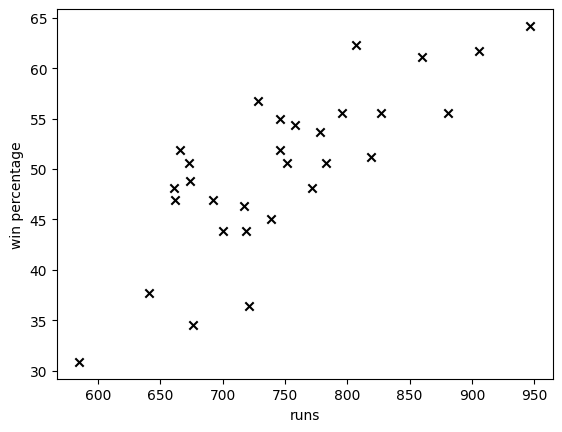

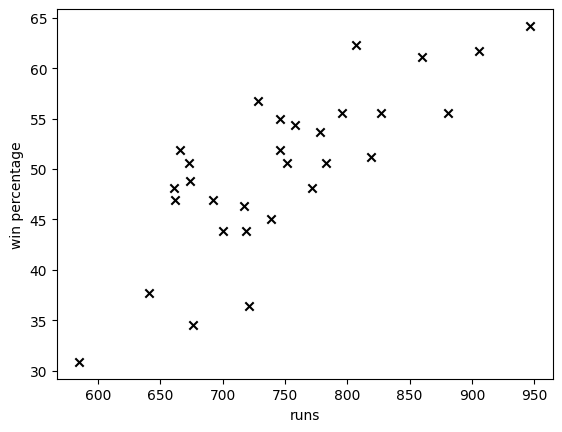

In [2480]:
import json # My data is saved as a dictionary in json format, so we must use the json library to load it here
import matplotlib.pyplot as plt

wp_r_2023 = json.load(open('./wp_r_2023.json',))
fig, ax = plt.subplots()
for team in wp_r_2023.keys():
    ax.scatter(wp_r_2023[team]["runs"], wp_r_2023[team]["win_percentage"], marker='x', c='k')
ax.set_xlabel('runs')
ax.set_ylabel('win percentage')
fig

Let's say I start with a random y-intercept (placed at 0 - 0 runs, 0 wins) and offer a few different slopes. Let's take a look at those slopes on the data.

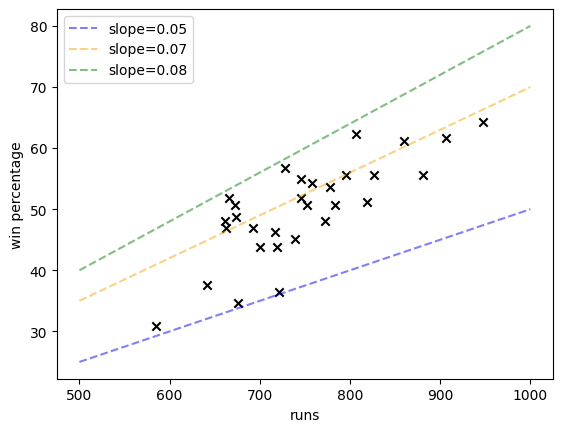

In [2481]:
def regression_line(x: float, m: float, b: float) -> float:
    return (m * x) + b

temp_b = 0
m_vals = [0.05, 0.07, 0.08]
regression_colors = ['blue', 'orange', 'green']
for idx, m_val in enumerate(m_vals):
    ax.plot([500, 1000], [regression_line(500, m_val, temp_b), regression_line(1000, m_val, temp_b)], label=f"slope={m_val}", linestyle='--', alpha=0.5, c=regression_colors[idx])
ax.legend()
fig

It is clear that there are big differences in the RSS values for each of these slopes. The further away the data points are from the line of best fit, the greater the RSS value. Here are those differences for the three different slope values:

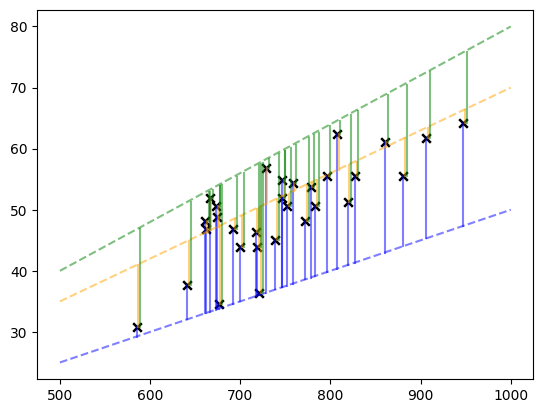

In [2482]:
x_vals = [wp_r_2023[team]["runs"] for team in wp_r_2023.keys()]
y_vals = [wp_r_2023[team]["win_percentage"] for team in wp_r_2023.keys()]
fig5, ax5 = plt.subplots() # This figure was added after the other examples in the multivariable calculus method of calculating minimum values, hence the use of number 5
for idx, m_val in enumerate(m_vals):
    x_offset = idx * 2 # This is just to keep the difference lines from overlapping
    for idx2, y_val in enumerate(y_vals):
        ax5.scatter(x_vals[idx2], y_val, marker='x', c='k')
        # Now let's plot the distance from the y-val to the modeled y
        modeled_y = regression_line(x_vals[idx2], m_val, temp_b)
        if y_val > modeled_y:
            ax5.plot([x_vals[idx2]+x_offset, x_vals[idx2]+x_offset], [modeled_y, y_val], c=regression_colors[idx], alpha=0.5)
        else:
            ax5.plot([x_vals[idx2]+x_offset, x_vals[idx2]+x_offset], [y_val, modeled_y], c=regression_colors[idx], alpha=0.5)
    ax5.plot([500, 1000], [regression_line(500, m_val, temp_b), regression_line(1000, m_val, temp_b)], label=f"slope={m_val}", linestyle='--', alpha=0.5, c=regression_colors[idx])
    fig5

You can see from the above graph that the distances between data points and regression lines are very different for the different slopes.

Summing the square of these differences gives us the RSS and if we were to plot the RSS values for each of the slopes it would look like this:

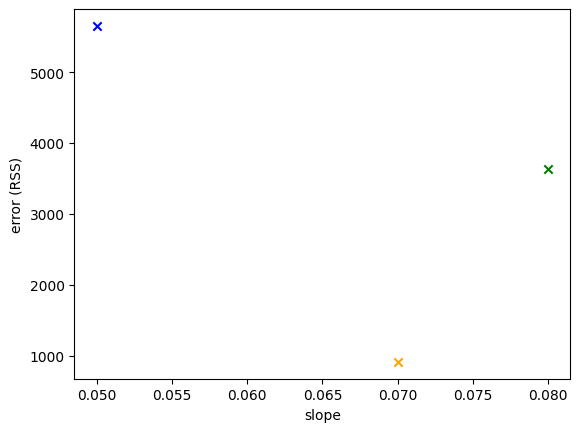

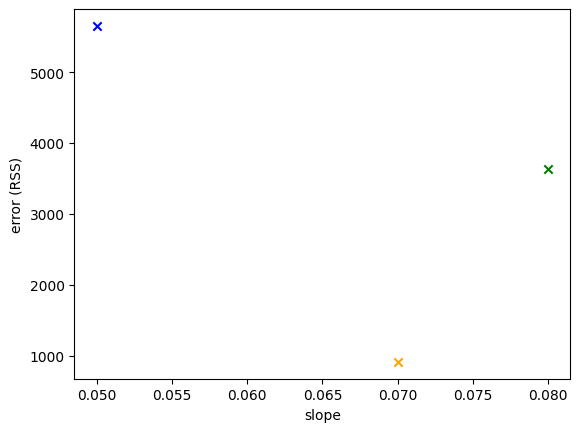

In [2483]:
fig2, ax2 = plt.subplots()
for idx, m_val in enumerate(m_vals):
    temp_rss = residual_sum_of_squares(y_vals, x_vals, m_val, temp_b)
    ax2.scatter(m_val, temp_rss, marker='x', color=regression_colors[idx])
ax2.set_xlabel("slope")
ax2.set_ylabel("error (RSS)")
fig2

What we see from this plot of RSS values is that setting the slope of the line to 0.07 offers the lowest difference of the points we chose; however, we cannot say if it is the lowest *possible* error. To find this out we need to run more examples.

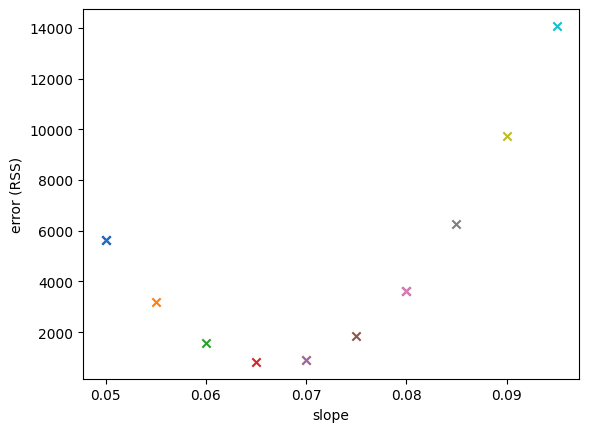

In [2484]:
import numpy as np

m_vals = np.arange(0.05, 0.1, 0.005)
for m_val in m_vals:
    temp_rss = residual_sum_of_squares(y_vals, x_vals, m_val, temp_b)
    ax2.scatter(m_val, temp_rss, label=f"slope={m_val}", marker='x')
ax2.set_xlabel("slope")
ax2.set_ylabel("error (RSS)")
fig2

We can see that while 0.07 was close to our minimum RSS value, 0.065 looks like a better approximation. We must keep in mind, however, that this result is plotting multiple slope values assumeing a y-intercept of 0. How can we be sure that the y-intercept should be 0? Let's flip the approach to now set the slope value to the approximate correct value (~0.065) and then change the y-intercept.

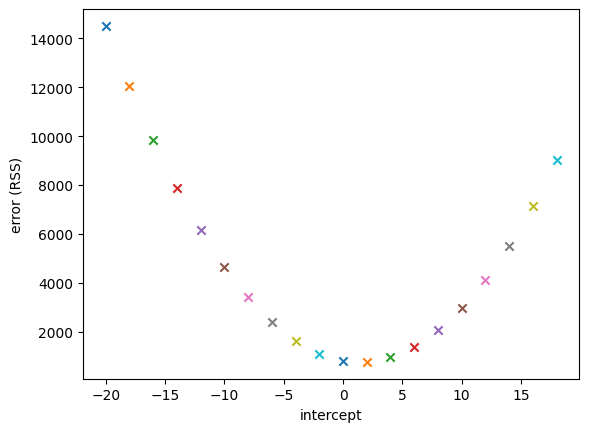

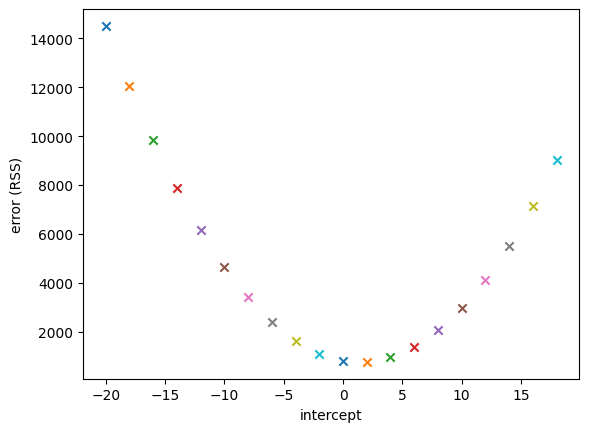

In [2485]:
fig3, ax3 = plt.subplots()
temp_m = .065
b_vals = np.arange(-20, 20, 2)

for b_val in b_vals:
    temp_rss = residual_sum_of_squares(y_vals, x_vals, temp_m, b_val)
    ax3.scatter(b_val, temp_rss, label=f"slope={m_val}", marker='x')
ax3.set_xlabel("intercept")
ax3.set_ylabel("error (RSS)")
fig3

Again, our initial guess of 0, while close, is slightly off and it is likelier that the y-intercept should be 2; however, given that we have two values that are changing this ping-ponging between finding values that give minimial error is not only inefficient but could cause confusion/error/overlooking certain things, etc. 

### **5.1.2 Multivariable Calculus Approach to Finding Best Fit**

The best way to approach this is to find the minimum value of the RSS with respect to both slope and intercept using multi-variable calculus approaches. By taking the derivative of the RSS with respect to (w.r.t.) both *m* and *b* and setting both of those derivatives to 0 we can find our the values that minimize RSS. Here's what that would look like. First, a refresher of the RSS function:

RSS = $\Sigma_{i=1}^{n} (\hat{y}_{i} - (m * x_{i} + b))^2$

The partial derivative w.r.t. m looks like the following (remember to use the chain rule!)...

$\delta_{RSS} / \delta_{m} = \Sigma_{i=1}^{n} 2 * (y_{i} - (m * x_{i} + b)) * -x_{i}$

...and w.r.t. b is:

$\delta_{RSS} / \delta_{b} = \Sigma_{i=1}^{n}  2 * (y_{i} - (m * x_{i} + b)) * -1$

*NOTE: Moving forward I am dropping the sigma notation of i= and n, just know that for all of the below equations we will be taking the sum of the entire sample.*

By setting both equations to zero we are **finding the values of m and b that minimize our RSS (derivative=0)**. We can also simplify these equations to make them easier to work with. That step looks like this:

$\Sigma (y_{i} - (m * x_{i} + b))(-x_{i})$ = $\Sigma x_{i} * y_{i} - \Sigma m * x_{i}^2 - \Sigma b * x_{i}$ = 0

$\Sigma (y_{i} - (m * x_{i} + b))(-1) = \Sigma y_{i} - \Sigma m * x_{i} - \Sigma b$ = 0

We can further rearrange these equations to find easily solvable partial derivatives by making the following substitutions:

$\Sigma b = n * b$ where n is the number of data points since b will never be changing

$\Sigma variable * x_{i} = variable * \Sigma x_{i}$ when the variable is constant w.r.t. $x_{i}$

We are then left with this:

$b * \Sigma x_{i} - m * \Sigma x_{i}^2 = \Sigma x_{i} * y_{i}$

$n * b - m * \Sigma x_{i} = \Sigma y_{i}$

All that's left is some algebra to isolate the *m* and *b* variables and we can easily find our result.

m = $ n(\Sigma x_{i} * y_{i}) - (\Sigma x_{i})(\Sigma y_{i})  /  ( n(\Sigma x_{i}^2) - (\Sigma x_{i})^2 )$

b = $ (\Sigma y_{i})(\Sigma x_{i}^2) - (\Sigma x_{i})(\Sigma x_{i} * y_{i})  /  ( n(\Sigma x_{i}^2) - ({\Sigma x_{i}})^2 ) $

Using these formulae with our current data we get:

In [2486]:
sigma_y = sum(y_vals)
sigma_x = sum(x_vals)
sigma_x_squared = sum([x**2 for x in x_vals])
sigma_x_y = sum([x * y_vals[i] for i, x in enumerate(x_vals)])
n = len(x_vals)

m = ((n * sigma_x_y) - (sigma_x * sigma_y)) / ((n * sigma_x_squared) - (sigma_x**2))
b = ((sigma_y * sigma_x_squared) - (sigma_x * sigma_x_y)) / ((n * sigma_x_squared) - (sigma_x**2))
print(f"m={m} || b={b}")

m=0.07639642623562688 || b=-7.124154443919685


As we printed out from the above cell, our *m* value actually was closer to 0.07 than 0.065 and our *b* value is negative! It seems unlikely that we would have managed to find those values simply running many iterations of our pick-and-choose style of finding minimum *m* and *b* values. Now, let's plot our best-fit line using our calculated *m* and *b* values.

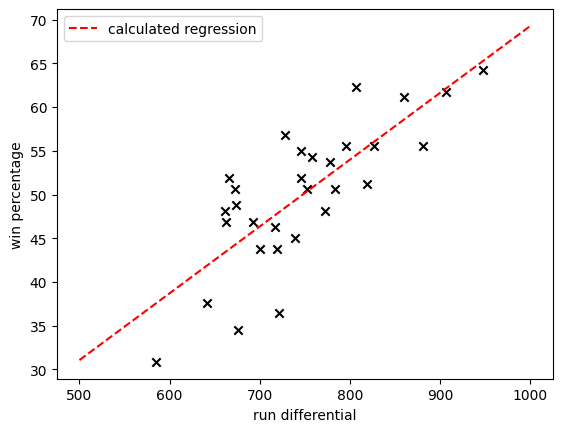

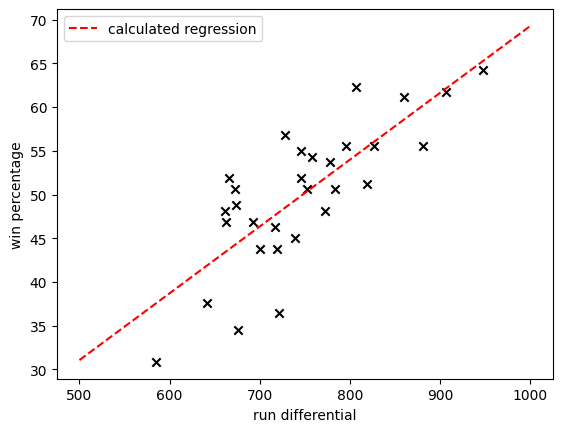

In [2487]:
fig4, ax4 = plt.subplots()
for team in wp_r_2023.keys():
    ax4.scatter(wp_r_2023[team]["runs"], wp_r_2023[team]["win_percentage"], marker='x', c='k')
ax4.set_xlabel('run differential')
ax4.set_ylabel('win percentage')
ax4.plot([500,1000], [regression_line(500,m,b), regression_line(1000,m,b)], label='calculated regression', linestyle='--', color='r')
ax4.legend()
fig4

There we go, this line looks pretty good! We could extend the principles of the multivariable calculus approach to multiple dimensions if need be; however, an alternative option would be to use matrix mathematics.

### **5.1.3 Matrix Approach to Linear Regression**

One of the benefits to using matrices is that if/when we want to expand our fit to multiple dimensions all of the math will be exactly the same, as opposed to multivariable calculus where we would have to extend our derivations and function solving. Let's establish the basics of using matrices using the same data as before, only now the data will be in matrices.

The dependent variables will be in a vector of length n, **y**, where n is the number of samples in our data. As before, **$\hat{y}$** is the estimate of our data based on our best-fit parameter values (m and b). The independent variables will be in an nx2 matrix, **X**, where the first column is a series of 1s and the second column is our x values (explained later). Finally, the parameter values themselves will be in a px1 vector, *$\beta$*, where *p* is the number of parameters in our fit function (in the case of our simple regression, p=2 (*m* and *b*)). Our regression line formula looks like this...

$\hat{y} = X * \beta$

...and the matrices themselves look like this:
$$
y = 
\left(\begin{array}{cc} 
y_{0}\\
y_{1}\\
...\\
y_{n}
\end{array}\right)

X =
\left(\begin{array}{cc} 
1 & x_{0}\\ 
1 & x_{1}\\
... & ...\\
1 & x_{n}
\end{array}\right)

\beta =
\left(\begin{array}{cc} 
b\\
m
\end{array}\right)
$$ 

Often in linear algebra this is alternatively expressed as $b = A * x$ where they use **b** instead of **Y**, **A** instead of **X** and **x** instead of **$\beta$**. For simplicity and continuity sake, I will continue with **Y** = **X** * $\beta$. 

To find the RSS in matrix notation let's first consider what happens when using matrix mathematics on our formula here. By multiplying **X** and **$\beta$** we get an nx1 matrix, or vector (nxp * px1 = nx1). Each row of this new **X** * **$\beta$** matrix consists of the sum of 1 * b (**X** column 1 times **$\beta$** row 1) and $x_{row}$ * m (**X** column 2 times **$\beta$** column 2). Essentially, we have solved each individual data point's $mx + b$ value. To get our RSS we need to take the difference of this value from our measured y in **y** and then square it. First, we can subtract the resulting **X** * **$\beta$** from **y** to get each corresponding $y_{row} - (b + m*x_{row})$. Then, to square the values we can multiply the transpose of this resulting matrix by itself. That results in the following formula:

RSS($\beta$) = (**Y** - **X** * $\beta$)$^{T}$ (**Y** - **X** * $\beta$)

What's really nice about this approach is that if we have data sets with multiple parameters we can just add the necessary rows to **Y** and **$\beta$** and columns to **X** to accomodate those dimensions, but more on that later. Let's do a quick comparison of our RSS values using both the matrix approach and the for-loop formula we used in the multivariable calculus example.

In [2488]:
matrix_y = np.asmatrix(y_vals).T
matrix_x = np.asmatrix([np.ones(len(x_vals)), x_vals]).T
beta = np.asmatrix([b, m]).T
difference_matrix = matrix_y - np.matmul(matrix_x, beta)

matrix_rss = np.matmul(difference_matrix.T, difference_matrix)

for_loop_rss = residual_sum_of_squares(y_vals, x_vals, m, b)

print(f"by matrix RSS = {matrix_rss}   ...   by for-loop RSS = {for_loop_rss}")


by matrix RSS = [[740.69513877]]   ...   by for-loop RSS = 740.6951387689239


As you can see, the matrix approach gives us the same RSS value, which is to be expected as we used the same values of b and m in both approaches (this was done more to demonstrate that we arrive at the same values using the two approaches). How can we find the values of m and b using matrix mathematics? It's actually very similar to our previous approach.

First, we can rewrite the RSS formula as the square of the norm of the initial difference vector, like this:

RSS($\beta$) = (**Y** - **X** * $\beta$)$^{T}$ (**Y** - **X** * $\beta$) = ||**Y** - **X** * $\beta||^2$

The *norm*, in this case the $L_{2}$ norm, of a vector finds the Euclidean distance of the total vector using the Pythagorean theorem for each point in the vector. Essentially, for a vector **A**, the norm, ||**A**||, is equal to $$ ||A|| = \sqrt{a_{0}^{2} + a_{1}^{2} + ... + a_{n}^{2}}$$ where $a_{i}$ is each data point in the vector. When each a in the norm is replaced with our difference vector values (e.g. $y_{i} - (b + m * x_{i})$), we essentially get the square root of our residual sum of squares - in fact, the norm is often referred to as an SRSS, the **s**quare **r**oot of the **s**um of **s**quares. By simply squaring this norm, we then get the square of the square root of the sum of squares... or simply, the residual sum of squares.

The next step is to differentiate w.r.t. $\beta$ and set to 0 to find our minimum, and we get:

**X**$^{T}$ * (**y** - **X** * **$\beta$**) = 0

To solve for $\beta$ we must isolate it and end up with our assumed parameters ($\hat{\beta}$):

(**X**$^{T}$ * **y**) - (**X**$^{T}$ * **X** * $\hat{\beta}$) = 0 ...

**X**$^{T}$ * **y** = **X**$^{T}$ * **X** * $\hat{\beta}$ ...

(**X**$^{T}$ * **X**)$^{-1}$ * **X**$^{T}$ * **y** = (**X**$^{T}$ * **X**)$^{-1}$ * **X**$^{T}$ * **X** * $\hat{\beta}$ ...

(**X**$^{T}$ * **X**)$^{-1}$ * **X**$^{T}$ * **y** = $\hat{\beta}$

Let's try this and compare it to the variables we calculated using multivariable calculus.

In [2489]:
x_t_x_inv = np.linalg.inv(np.matmul(matrix_x.T, matrix_x))
x_t_y = np.matmul(matrix_x.T, matrix_y)
beta_hat = np.matmul(x_t_x_inv, x_t_y)

print(f'by matrix math we found beta hat to be: {beta_hat}   ||   by calculus we found b={b} and m={m}')

by matrix math we found beta hat to be: [[-7.12415444]
 [ 0.07639643]]   ||   by calculus we found b=-7.124154443919685 and m=0.07639642623562688


Success! Using the matrix math approach has resulted in the same exact intercept and slope values as we found using multivariable calculus. There is one final approach that I want to discuss, because it is an important one in understanding dimensionality within matrices.

### **5.1.4 SVD Approach to Linear Regression**

The singular value decomposition (SVD) allows us to represent a single matrix as a product of three matrices, **U**, **$\Sigma$** and **V**$^{T}$. Typically, SVD is used in much more complex analyses than just a simple regression, but it can be used for regression as it has a few important properties. First, it is always guaranteed to exist meaning that whatever shape our **X** matrix has we can calculate its SVD. Second, it is always unique, so the properties from our SVD will only apply to our **X** and finally it can be used to easily find the inverse of a matrix, meaning that we can simplify our problem...

**y** = **X** * $\beta$

...by multiplying both sides by the inverse of **X** to isolate $\hat{\beta}$:

**X**$^{-1}$ * **y** = $\hat{\beta}$

Here's a real quick explanation of what each of the matrices in the SVD represents.

#### **U**

The columns of the **U** matrix have the same shape as our **X** matrix. They are arranged hierarchically meaning the first column is more important to the representations in our data than column two, which is more important than column three and so on. This matrix is also known as the 'left singular vectors.'

#### **$\Sigma$**

$\Sigma$ is a diagonal matrix of singular $\sigma$ values. It is also hierarchically organized, so $\sigma_{1}$ is greater than or equal to $\sigma_{2}$ which is greater than or equal to $\sigma_{3}$ and so on. The $\sigma$ values correspond with the respective columns of **U** and rows of **V** (or columns of **V**$^{T}$). The smaller the singular value is, the less important the corresponding **U** matrix columns are and the greater representation of our data there is in the first few columns of **U**.

#### **V**$^{T}$

Finally, **V**$^{T}$ has a similar interpretation as **U** does, only it reflects how the data is changing from datapoint to datapoint across the rows in our **X** matrix. So as **U** represents importance of certain aspects of our data within each datapoint, **V**$^{T}$ represents the importance of certain aspects of our data across datapoints, with each row of **V**$^{T}$ representing one consistent aspect of those datapoints. This brief overview is likely not terribly clear, especially for those of you that are unfamiliar with SVD or multi-dimensional data reduction techniques, so I would absolutely recommend you follow-up with the sources to which I am constantly referring (below).

As I mentioned, SVD can give us the inverse of any matrix. One property that both **U** and **V**$^{T}$ share is that both are unitary, meaning that multiplying each matrix by its transpose results in its identity matrix, meaning the transpose of each of these matrices is essentially its inverse. Here's how we can now use the SVD to solve our linear regression problem.

**X** $\beta$ = **y**

**X**$^{-1}$ **X** $\beta$ = **X**$^{-1}$ **y**

Cancel out the **X** matrix on the left and replace **X**$^{-1}$ with the Moore-penrose pseudoinverse of our SVD matrices on the right:

$\hat{\beta}$ = **V** **$\Sigma$**$^{-1}$ **U**$^{T}$ **y**

There you have it! All it takes to solve for our parameters is to use the inverse of the SVD multiplied by our dependent variable vector. Let's code it up and compare those results to what we have found using our two previous methods.

In [2490]:
u,s,v_t = np.linalg.svd(matrix_x, full_matrices=False)
#svd_beta = np.matmul(v_t.T, np.linalg.inv([s]), u.T, matrix_y)
svd_inverse = (v_t.T @ (np.linalg.inv(np.diag(s)) @ u.T))
print(svd_inverse.shape, matrix_y.shape)
svd_beta = svd_inverse @ matrix_y

print(f'SVD: {svd_beta}\nMatrix Math: {beta_hat}\nCalc: {b, m}')

(2, 30) (30, 1)
SVD: [[-7.12415444]
 [ 0.07639643]]
Matrix Math: [[-7.12415444]
 [ 0.07639643]]
Calc: (-7.124154443919685, 0.07639642623562688)


Success! We have found the same values for intercept and slope in all three approaches. Let's wrap up this lesson on linear regression by applying these principles to some multi-dimensional problems.

### **5.1.5 Linear Regression in Multiple Dimensions**

I would like to continue to visualize these results, so first I will stick to a 3-dimensional result and then finish up with one larger-dimension problem. Let's start by simply adding a second dimension to our previous data, runs against. Let's first look atthe data.

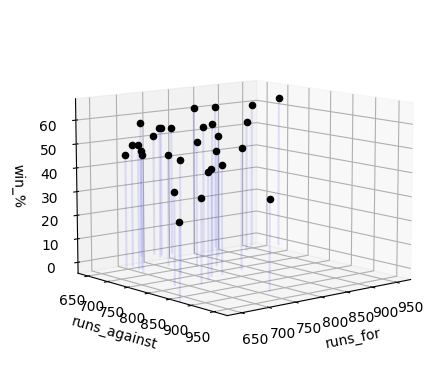

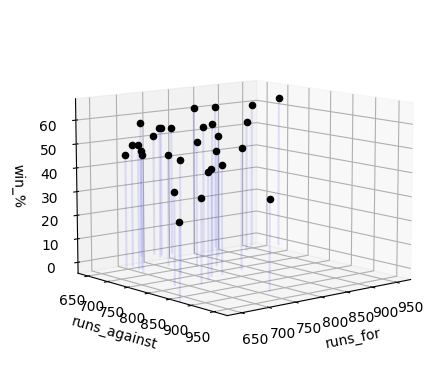

In [2491]:
runs_for_against_wp = json.load(open("wp_rfa_2023.json",))
X = np.matrix([np.ones(len(runs_for_against_wp.keys())),
            [runs_for_against_wp[team]["runs_for"] for team in runs_for_against_wp.keys()],
            [runs_for_against_wp[team]["runs_against"] for team in runs_for_against_wp.keys()]])

Y = np.array([runs_for_against_wp[team]["win_percentage"] for team in runs_for_against_wp.keys()])

fig6 = plt.figure()
ax6 = fig6.add_subplot(projection='3d')
ax6.view_init(elev=10, azim=50)

for idx, val in enumerate(Y):
    x = np.array(X.item(1,idx))
    y = np.array(X.item(2,idx))
    z = np.array(val)
    ax6.scatter(x,y,z, marker='o', c='k', alpha=1.)
    ax6.plot([x,x], [y,y], [0,z], linestyle='-', c='b', alpha=0.1)
ax6.set_xlabel('runs_for')
ax6.set_ylabel('runs_against')
ax6.set_zlabel('win_%')
ax6.invert_yaxis()
fig6


It seems pretty clear, and is likely obvious to most of us, that as you increase runs scored and decrease runs against, a team's winning percentage is likely to go up. But how well correlated are these two to win percentage?Is one more important than the other? For that, let's run a quick regression on this data. 

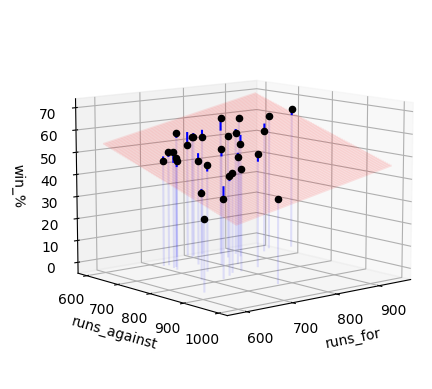

In [2492]:
U, S, V = np.linalg.svd(X.T, full_matrices=False)
SVD_inverse = (V.T @ np.linalg.inv(np.diag(S)) @ U.T)
SVD_BETA = SVD_inverse @ Y

def best_fit_plane(x, y, betas):
    return betas.item(0,0) + (x * betas.item(0,1)) + (y * betas.item(0,2))

for val in np.arange(600,1000,5):
    ax6.plot([600,950], [val,val], [best_fit_plane(650, val, SVD_BETA), best_fit_plane(950, val, SVD_BETA)], color='r', alpha=0.1)
for idx, val in enumerate(Y):
    x = np.array(X.item(1,idx))
    y = np.array(X.item(2,idx))
    z = np.array(val)
    ax6.plot([x,x], [y,y], [best_fit_plane(x, y, SVD_BETA), z], linestyle='-', c='b', alpha=1)
fig6

The red plane is the plane of best fit and the dark blue lines indicate how far each datapoint is from that plane. Let's step it up into even more dimensions now by looking at BABIP in 2023 (following the shift rule change). I have a hypothesis that BABIP has to do with how well a ball is hit as measured by barrel percentage, exit velocity, launch angle and location, so we will include those in our analysis. I also think that a hitter's patience can be indicative of their willingness to wait for the right pitch, so we'll consider strike out and walk rates. I have selected '+' stats where available for this query, as those stats come normalized to the league averages and will set all variables on equal footing as far as magnitude goes. Where unavailable, I normalized them myself. So, our rows are (in order):

    Barrel%+

    EV+
    
    LA+
    
    Pull%+
    
    Cent%+
    
    Oppo%+
    
    Soft%+
    
    Hard%+
    
    BB%+
    
    K%+

and the final row is our BABIP+, which will be separated out into our **y** vector.

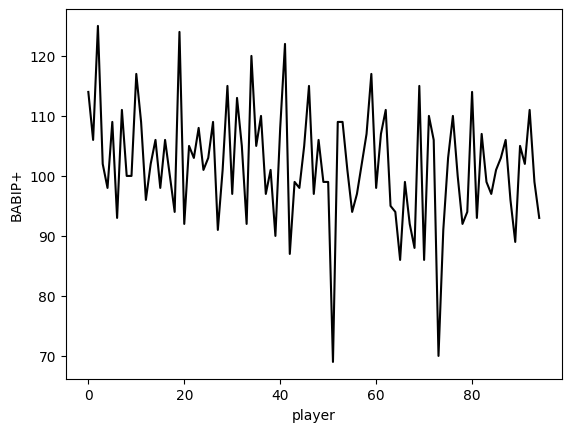

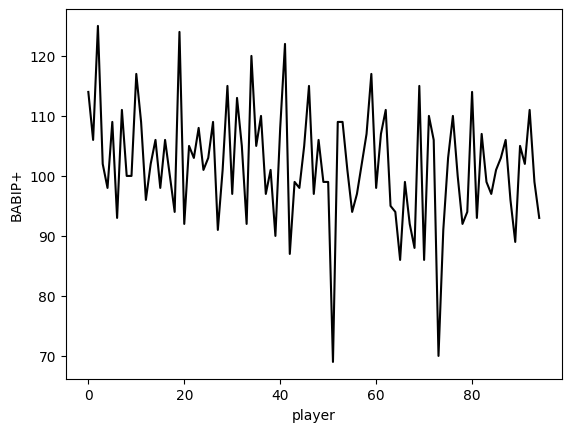

In [2493]:
batting_data = np.loadtxt(open("batting_stats.csv", "rb"), delimiter=",", skiprows=1)[:,1:]
batting_X = batting_data[:,:-1]
batting_y = batting_data[:,-1]

fig7, ax7 = plt.subplots()
ax7.plot(range(len(batting_y)), batting_y, c='k', label='True BABIP+')
ax7.set_xlabel('player')
ax7.set_ylabel('BABIP+')
fig7

The above graph shows all of the BABIP+s in the dataset plotted randomly (ordered by fangraphs ID). We should be able to come close to replicating this random line.

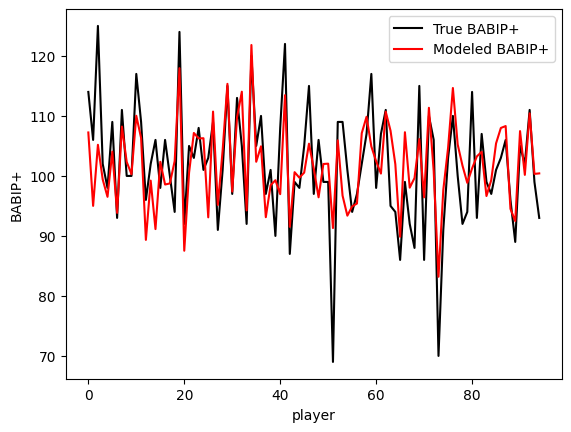

In [2494]:
U_bat, S_bat, V_bat = np.linalg.svd(batting_X, full_matrices=False)
SVD_inverse_bat = (V_bat.T @ np.linalg.inv(np.diag(S_bat)) @ U_bat.T)
SVD_BETA_bat = SVD_inverse_bat @ batting_y

batting_y_hat = batting_X @ SVD_BETA_bat

ax7.plot(range(len(batting_y_hat)), batting_y_hat, c='r', label="Modeled BABIP+")
ax7.legend()
fig7

As you can see from the line above, there are a number of instances where the data fits okay but there are also a number of points where the true BABIP+ is much greater or much lower than the model. Let's graph these in increasing order of true BABIP+ and see if that changes anything in our graph.

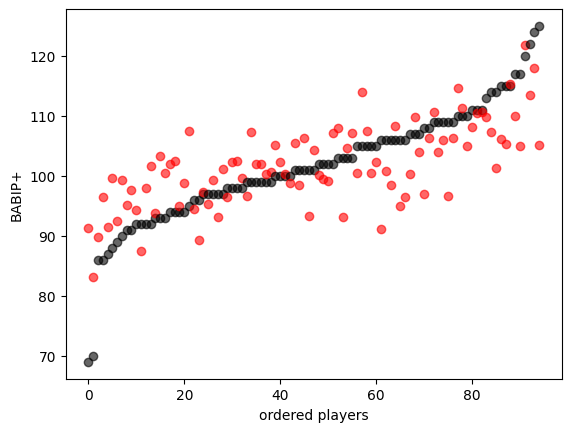

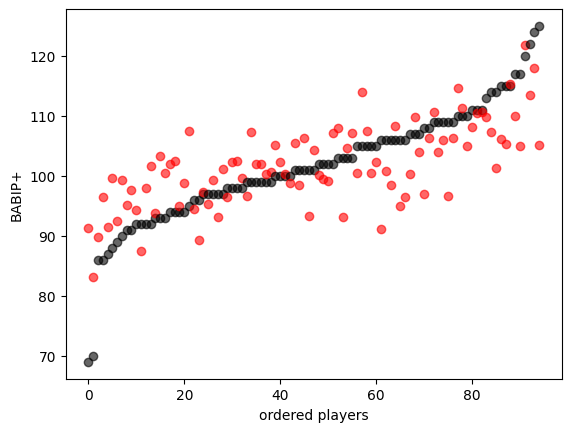

In [2495]:
idx_sort = batting_y.argsort()
batting_y = batting_y[idx_sort]
batting_y_hat = batting_y_hat[idx_sort]

fig8, ax8 = plt.subplots()
for idx, val in enumerate(batting_y):
    ax8.scatter(idx, val, c='k', alpha=0.6)
    ax8.scatter(idx, batting_y_hat[idx], c='r', alpha=0.6)
ax8.set_xlabel('ordered players')
ax8.set_ylabel('BABIP+')
fig8

You can see that while the modeled data is not tightly clustered to the true BABIP+ values, there is still a small capturing of the trend within the model. I, personally, would not be satisfied with this model for predicting BABIP+, but it can still highlight a few important things. Let's end this section by looking at the overall values of the parameters in $\beta$.

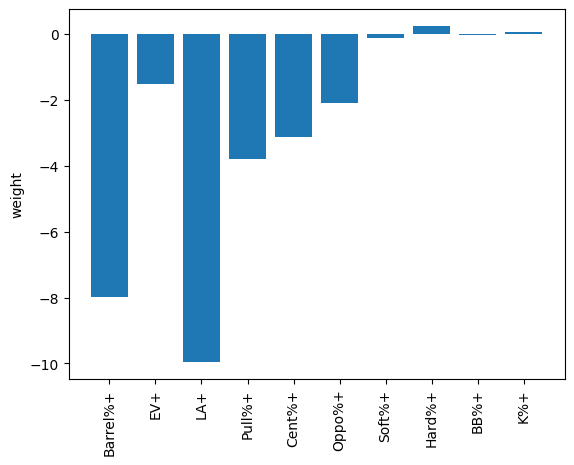

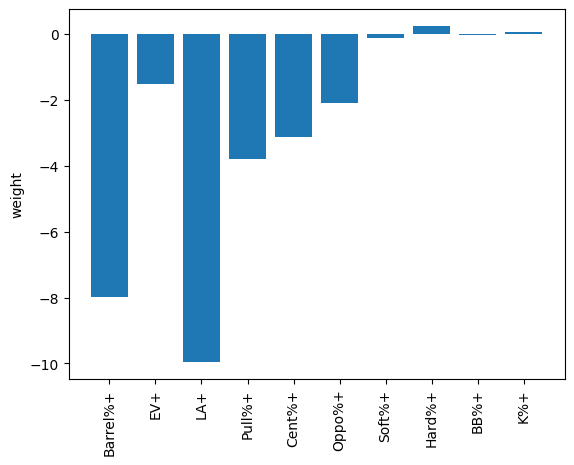

In [2496]:
SVD_BETA_bat = SVD_BETA_bat[1:] # Remove the first value as that is the intercept value
fig9, ax9 = plt.subplots()
batting_parameter_labels = ["Barrel%+", "EV+", "LA+", "Pull%+", "Cent%+", "Oppo%+", "Soft%+", "Hard%+", "BB%+", "K%+"]
ax9.bar(range(len(SVD_BETA_bat)), SVD_BETA_bat, label=batting_parameter_labels)
plt.xticks(ticks=range(len(batting_parameter_labels)), labels=batting_parameter_labels, rotation='vertical')
ax9.set_ylabel('weight')
fig9

What's really interesting to me is that all of the parameters outside of Hard%+ and K%+ are negatively correlated with BABIP. They do say that BABIP is mostly luck, especially given that you cannot dictate where players stand (only MLB gets to do that) and I would say this model would be evidence of that.

#### **5.1.6 Packages That Can Do Linear Regression For You**

Now is the part of the chapter where I let you know that all of the coding we've done previously was for naught because there are packages that will automatically calculate our linear regressions for us. For this demonstration I'm reverting back to the previous 2D regression on runs scored vs. winning percentage. Both `numpy` and `scipy` have linear regression functions.

In [2497]:
from scipy import stats

matrix_x = matrix_x[:, [1,0]] # With numpy linalg the ones column must be the last column
#m_scipy, b_scipy, r, p, se = stats.linregress(x_vals, y_vals)
res = stats.linregress(x_vals, y_vals) # scipy linregress takes in one dimensional data
m_numpy, b_numpy = np.linalg.lstsq(matrix_x, matrix_y)[0]

print(f"original values using calculus: m={m}, b={b}\nUsing matrix math: m={beta_hat[1]}, b={beta_hat[0]}\nUsing scipy: m={res.slope}, b={res.intercept}\nUsing numpy: m={m_numpy} b={b_numpy}")

original values using calculus: m=0.07639642623562688, b=-7.124154443919685
Using matrix math: m=[[0.07639643]], b=[[-7.12415444]]
Using scipy: m=0.07639642623562828, b=-7.124154443920453
Using numpy: m=[[0.07639643]] b=[[-7.12415444]]


/tmp/ipykernel_18664/2903574272.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_numpy, b_numpy = np.linalg.lstsq(matrix_x, matrix_y)[0]


Pretty cool! These packages found the same b and m values that we did using all of our math. I know it seems tedious to have gone through all of the theory underlying RSS and lienar regression when we can do it all in one line using these packages, but I hope you see the value in understanding the mathematics upon which these packages are built.

#### **5.1.7 Further Reading**
Below are some further readings and videos for those of you that are unsatisfied with my explanations and want to dive further.

I've always been a huge fan of [StatQuest](https://www.youtube.com/watch?v=nk2CQITm_eo&list=PLblh5JKOoLUIzaEkCLIUxQFjPIlapw8nU&index=2), [Dr. Steve Brunton](https://www.youtube.com/watch?v=EDPCsD6BzWE) and [MIT's OpenCourseWare](https://www.youtube.com/watch?app=desktop&v=YwZYSTQs-Hk).

[This paper from Colan F Biemer discusses RSS derivation](https://bi3mer.github.io/blog/post_30/biemer_least_squares.pdf)

[This blog post has a good in-depth dive behind least squares regression lines](https://uedufy.com/mastering-the-least-squares-regression-line/)

[This blog post by Dr. Marco Taboga discusses normal equations in regression](https://www.statlect.com/glossary/normal-equations)

It's never a bad idea to read the documentation for the packages you use when coding, here's the relevant sections for [numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) and [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)